## **Group Project:** Implementing Decision Tree from scratch

In [25]:
import numpy as np
from collections import Counter

Let's First Implement our loss function the entropy, we could have also use Gini impurity.

In [26]:
def entropy(y):
  """ 
  For a given list of class (integers), return the entropy.
  Exemple: [0,0,1,0,2,1] should out 1.45
  """
  count = np.bincount(y)
  # Count number of occurrences of each value in array of non-negative ints.
  scaled = count/len(y)
  # Return entropy
  return -np.sum([i*np.log2(i) for i in scaled if i>0])

In [27]:
""" Let's test it out with an exemple:
[0,0,1,0,2,1]
Class 0: p(0)=1/2 log(1/2)=-1
Class 1: p(1)=1/3 log(1/3)=-1.58
Class 2: p(2)=1/6 log(1/6)=-2.58
Entropy =1.45
"""
exemple= [0,0,1,0,2,1]
entropy(exemple)

1.4591479170272448

Let's define our first class: **Node**, which is more an helper class that will be used during the tree growing.

In [48]:
class Node:
  """
  Store information for our node
  """
  def __init__(self,feature=None,threshold=None, left=None, right=None,*,value=None):
      """
      feature: the feature used to make the split
      threshold : the threshold valued used to make the split
      right: which node is the right split
      left: which node is the left split
      value: if it's the terminal node, store what is the majority class
      """
      self.feature = feature
      self.threshold = threshold
      self.left = left
      self.right = right
      self.value = value

  def is_leaf_node(self):
      #Check if it's a leaf/terminal node: return boolean
      return self.value is not None

Let's define our second class: **DecisionTree**.  
It's a complex class, that grow a tree recursively. We tried to divide into helper functions and commenting extensively to make the code clearer.

In [83]:
class DecisionTree:

  def __init__(self,min_samples_split=2,max_depth=10, n_feats=None):
    """
    Input:
      min_samples_split: How many minimum samples to keep on growing the tree, 2 by default
      max_depth: maximum depth of the tree, 10 by default
      n_feats: how many features would be used, if we don't use all of them. We could use a random subset of them, such as in random forest.
    """
    self.min_samples_split = min_samples_split
    self.max_depth = max_depth
    self.n_feats = n_feats
    self.root = None


  def fit(self, X, y):
    """
    Train the tree on the training data set
    Input:
      X: input
      y: classes
    """
    #Check if the n_feats is equal to the number of features in the input(X). If it's not the case it takes the minimum beetween the 2.
    self.n_feats = X.shape[1] if not self.n_feats else min(self.n_feats, X.shape[1])
    #Call the _grow_tree method
    self.root = self._grow_tree(X,y)


  def _grow_tree(self,X, y, depth=0):
    """
    Grow the tree recursively and taking care of the stopping criterias.
    Input:
      X: input
      y: classes
      depth: the actural depth of the tree, use to keep track
    Output: 
      The decision tree created recursively with multiple nodes.
    """

    n_samples= X.shape[0] #Size of training set
    n_features = X.shape[1] #Number of features
    n_labels = len(np.unique(y)) #Number of diffrent classes

    #Check the 3 stopping criterion, if one of them is fullfill, we are at a leaf node
    if (depth >= self.max_depth or n_labels==1 or n_samples < self.min_samples_split):
      leaf_value=self._most_common_label(y)
      return Node(value = leaf_value)

    #In the case we are not using all featurs, select randomly the index of the usen features
    feat_idxs = np.random.choice(n_features, self.n_feats, replace = False)

    #Using the _best_criteria method to grab the best feature and threshold for the split
    best_feat, best_thresh = self._best_criteria(X,y, feat_idxs)

    #Find indices after the split
    left_idxs = np.argwhere(X[:,best_feat]<= best_thresh).flatten()
    right_idxs = np.argwhere(X[:,best_feat]> best_thresh).flatten()

    #Grow recursively, using only the concerned rows indexes and incrementing the depth
    left = self._grow_tree(X[left_idxs,:], y[left_idxs], depth+1)
    right = self._grow_tree(X[right_idxs,:], y[right_idxs], depth+1)
    return Node(best_feat, best_thresh, left, right)

  def _most_common_label(self,y):
    """
    From a list of label, return the most common one
    Input:
      y: list of classes
    Ouput:
      most_common: the most common label in the list
    """
    counter = Counter(y) #Return the number of occurences for each label, using counter from library
    most_common = counter.most_common(1)[0][0] #Return the value of the most frequent label
    return most_common

  def _best_criteria(self,X, y, feat_idxs):
    """
    Do a greedy search among all features and all possible threshold to find the best split.
    Input:
      X: input
      y: classes
      feat_idxs: index of the features we will use
    Output:
      split_idx: best feature  to maximize information gain
      split_thresh: best threshold value to maximize Informaton gain
    """
    best_gain= -1 #Setting up with the lower gain
    split_idx, split_thresh = None,None #Setting up variables

    for feat_idx in feat_idxs: #Iterating in all features
      X_column = X[:, feat_idx] #Keep input for this feature
      thresholds = np.unique(X_column) #Remove duplicate to avoid testing same split multiple time
      for threshold in thresholds: #Test every  possible thresholds
        gain= self._information_gain(y,X_column, threshold) #Compute the information gain fo this threshold

        #If the gain is better than previous best, keep it in memory.
        if gain > best_gain:
          best_gain = gain
          split_idx = feat_idx
          split_thresh = threshold

    return split_idx,split_thresh


  def _information_gain(self, y, X_column, split_thresh):
    """
    We compute the information gain for a given split. 
    We use the formula of the information gain: Parent_entropy minus Weighted_Average of children's entropy.
    Input:
      X_column: the data for a given feature
      y: corresponding classes
      split_thresh: the threshold used here
    Output:
      Information gain with this split
    """
    #Compute parent entropy using the formula written before
    parent_entropy = entropy(y)
    #Retrieve the left and right index after the split
    left_idxs = np.argwhere(X_column <= split_thresh).flatten()
    right_idxs = np.argwhere(X_column > split_thresh).flatten()

    #If the split doesn't produce 2 groups, forget about it.
    if len(left_idxs) == 0 or len(right_idxs)==0:
      return 0

    #Compute entropy of the children nodes
    entropy_left = entropy(y[left_idxs])
    entropy_right = entropy(y[right_idxs])

    #Compute total information gain:
    n = len(y)
    n_l, n_r = len(left_idxs), len(right_idxs)
    return parent_entropy - ((n_l/n)*entropy_left + (n_r/n)*entropy_right)


  def predict(self, X):
    """
    Do predictions on the test data set going through the tree
    Input:
      X: List of inputs to predict
    Output:
      np array of the predicted labels
    """
    return np.array([self._traverse_tree(x,self.root) for x in X])

  def _traverse_tree(self,x,node):
    """
    Do prediction by going through the tree recursively starting from the root to the leaves
    Input:
      x: single input to predict
    Output:
      The label of the final node reached after traversing the tree
    """
    if node.is_leaf_node(): #Stppoing criterion, if the node is a leaf, we retrieve the value and stop the recursion.
      return node.value
    
    #Check for the given split in the node (feature, threshold), if we should continue the recursion with the left node or the right node.
    if x[node.feature] <= node.threshold:
      return self._traverse_tree(x,node.left) #Continue the traverse with the left node

    return self._traverse_tree(x,node.right) #Continue the traverse with the right node

## **Let's test our implementation:**

In [68]:
from sklearn.datasets import load_breast_cancer
from sklearn import model_selection
from sklearn.metrics import accuracy_score

cancer = load_breast_cancer()
X_train, X_test, y_train, y_test = model_selection.train_test_split(cancer.data, cancer.target, test_size=0.20, random_state=0)

clf = DecisionTree(max_depth=10)
clf.fit(X_train, y_train)

y_pred=clf.predict(X_test)
print("Accuracy:", accuracy_score(y_test,y_pred))

Accuracy: 0.9385964912280702


Let's try to compare with the decision tree implemented in sklearn

In [78]:
from sklearn import tree

my_accu=[]
sk_accu=[]
tested_depth=list(range(1,16))

for i in tested_depth:

  #sk accuracy
  sk = tree.DecisionTreeClassifier(max_depth=i)
  sk = sk.fit(X_train, y_train)
  y_pred = sk.predict(X_test)
  sk_accu.append(accuracy_score(y_test,y_pred))

  #Our Accuracy
  clf = DecisionTree(max_depth=i)
  clf.fit(X_train, y_train)
  y_pred=clf.predict(X_test)
  my_accu.append(accuracy_score(y_test,y_pred))

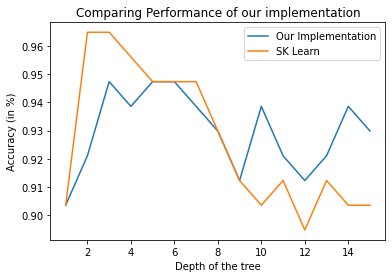

In [82]:
import matplotlib.pyplot as plt

#Plotting the comparison
plt.plot(tested_depth,my_accu, label = "Our Implementation")
plt.plot(tested_depth,sk_accu, label = "SK Learn")

plt.xlabel('Depth of the tree')
plt.ylabel('Accuracy (in %)')
plt.title('Comparing Performance of our implementation')

plt.legend()
plt.show()